# Solving the Poisson equation

In [1]:
import os
from pdb import set_trace as bp

# Set JAX to use CPU
os.environ['JAX_PLATFORM_NAME'] = 'cpu'


import jax.numpy as jnp
from jax import random
from jax import scipy 
import jax
print("Default JAX device:", jax.devices()[0])

import matplotlib.pyplot as plt
from utils_rough_pde import *

from jax.config import config
config.update("jax_enable_x64", True)

from jax import grad, hessian, jit



from utilities_kernel_matern import *
#from utilities_kernel_se import *

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Default JAX device: TFRT_CPU_0


C:\Users\Matthieu\AppData\Local\Temp\ipykernel_30860\1102486707.py:17: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# draw random values for the coefficients
key = random.PRNGKey(609)


s= 2
n_coef = 1000
n_evaluations = 2000
alpha = 2*s+1 + 0.25
print(s, alpha)
decay_u = alpha/2
L = 1 # Lenght of the domain
coef_u =  jnp.ones(shape = (1, ))/(jnp.arange(1, n_coef+1)**(decay_u)) 

coef_u = random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))
coef_f = coef_u*jnp.arange(1, n_coef+1)**(2)*jnp.pi**2*L**2


x = jnp.linspace(0, L, n_evaluations)
u_values = evaluate_function(x, coef_u, L=L)
f_values = evaluate_function(x, coef_f, L=L)






2 5.25


Text(0.5, 1.0, 'Squared coefficients of f')

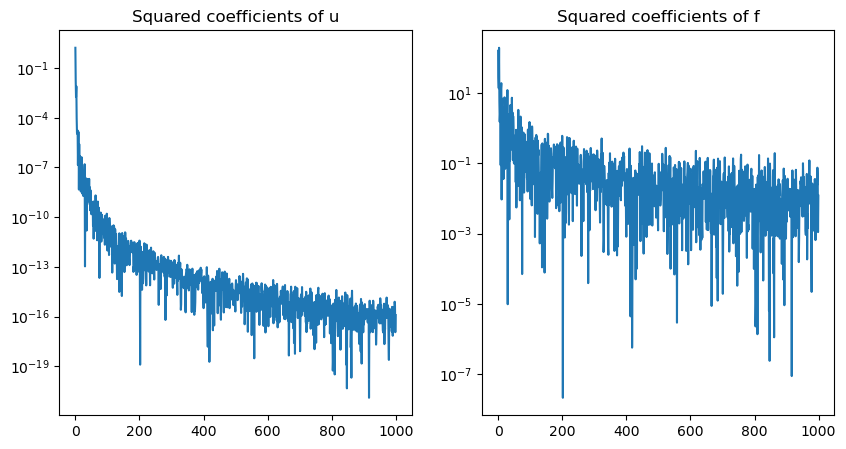

In [3]:

# Plot both the coeffients of u and f in 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(coef_u**2)
ax1.set_yscale('log')
ax1.set_title('Squared coefficients of u')
ax2.plot(coef_f**2)
ax2.set_yscale('log')
ax2.set_title('Squared coefficients of f')


Text(0.5, 1.0, 'Function f')

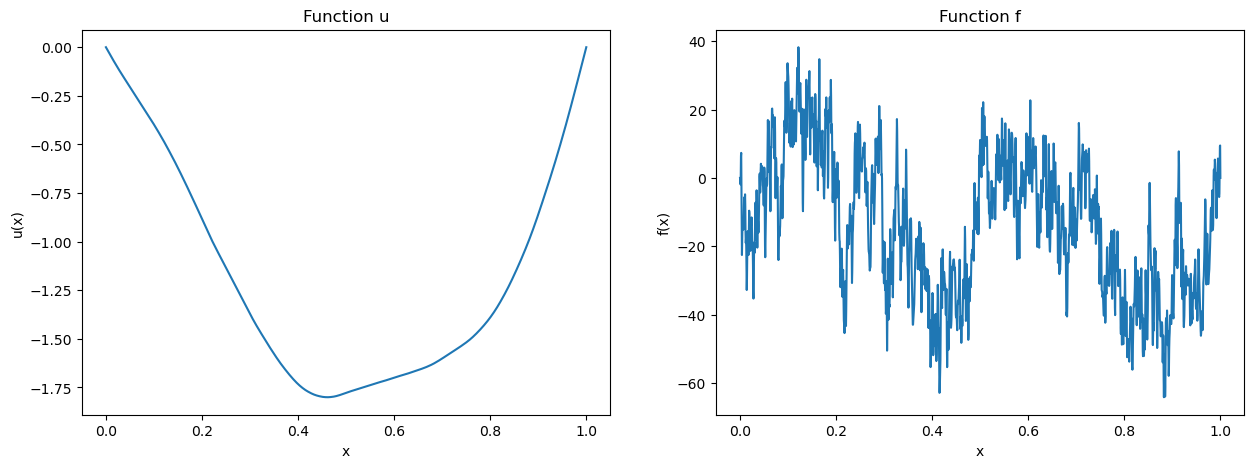

In [4]:
# Create 2 plots for the  function u and f
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values)
ax[0].set_xlabel("x")
ax[0].set_ylabel("u(x)")
ax[0].set_title("Function u")

ax[1].plot(x, f_values)
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].set_title("Function f")


In [5]:
# Solve the Poisson equation with increasing number of measurements
n_meas_min = 10
n_meas_max = 500

increment = 10
n_meas_list = jnp.arange(n_meas_min, n_meas_max + increment, increment, dtype=int)
# Boundary of the domain
lower, upper = 0.0, 1.0

boundary = jnp.array([[lower, upper]]).T

nugget_interior = 1e-7
nugget_boundary = 1e-12

In [6]:
from scipy.special import roots_legendre
n_order  = 35
x_q, w_q = roots_legendre(n_order)

# These are to compute the error in the L^2 and H^1 norm (we can afford to go much higher as we only evaluate two functions)
# The order needs to be very high to ensure the accuracy of the computation of the error
x_error, w_error = roots_legendre(3000)
x_error, w_error =  root_interval(x_error, w_error, [0,1])
# The true solution evaluated at the quadrature points (only required for computing the error)
u_error = evaluate_function(x_error, coef_u, L=L)

In [7]:
epsilon_values =  jnp.array([1/(n_meas_max*2)])
# Construct the measurements
loc_values = jnp.linspace(lower + epsilon_values[0], upper - epsilon_values[0],  int(L/(2*epsilon_values[0])))


support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
vol = support[:,1] - support[:,0]
N_test_functions = loc_values.shape[0]

In [8]:
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)
psi_matrix = indicator_vector(root_psi, epsilon_values, loc_values)

In [9]:
psi_matrix = psi_matrix * w_psi
# Compute the RHS of the linear system
f_quad = evaluate_function(root_psi, coef_f, L)
f_meas = vmap_integrate_f_test_functions(f_quad, psi_matrix)

In [10]:
# Creating the max min ordering

loc_values_boundary = jnp.hstack([jnp.array([lower, upper]), loc_values])
max_min_order = jnp.arange(loc_values.shape[0])
# max_min_order = build_max_min_ordering(loc_values_boundary[:, None],[0,1])
# max_min_order = max_min_order[2:] -2

In [11]:
# Reorganize the measurements according to the max min ordering
f_meas = f_meas[max_min_order]
# Reogarganize the psi matrix according to the max min ordering
psi_matrix = psi_matrix[max_min_order, :]
# Reorganize the root psi according to the max min ordering
root_psi = root_psi[max_min_order, :]

In [12]:
# Constructing the kernel matrix
length_scale = 1.0
theta = construct_theta(boundary,psi_matrix, root_psi, length_scale)


In [13]:
# Solving the system
i = n_meas_max
f_temp = f_meas[:i]
# Construct the RHS of the linear system
Y = jnp.block([jnp.zeros(shape = 2), f_temp])

# Construct the nugget
nugget = jnp.block([nugget_boundary*jnp.ones(shape = 2), nugget_interior*jnp.ones(shape = f_temp.shape[0])])
theta_temp = theta[:i+2, :i+2]
c = scipy.linalg.solve(theta_temp + nugget*jnp.eye(theta_temp.shape[0]), Y, assume_a='pos')


In [14]:
theta_temp.shape

(502, 502)

In [15]:
# Compute the numerical solution
pred = evaluate_prediction(x, c, length_scale, root_psi[:i], psi_matrix[:i], boundary)

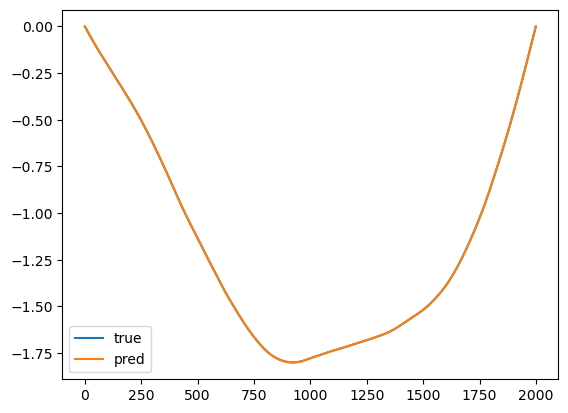

In [16]:
plt.plot(u_values, label = 'true')
plt.plot(pred, label = 'pred')

plt.legend()

In [17]:
def evaluate_prediction(x, c, length_scale, root_psi, psi_matrix, boundary):
    K_boundary = vmap_kernel(x,boundary, length_scale)
    K_interior = jnp.einsum('nmk,mk->nm',  vmap_laplacian_kernel_quad(x, root_psi[:, :, None], length_scale), psi_matrix)
    K_evaluate = jnp.block([[K_boundary, K_interior]])

    return jnp.squeeze(K_evaluate@c)


vmap_lapl_pred =jit(vmap(hessian(evaluate_prediction, argnums=0), (0, None, None, None, None, None)))

def evaluate_neg_lapl(x, c, length_scale, root_psi, psi_matrix, boundary):
    # This only works in the interior of the domain (which is fine for our purposes)
    # Also this only works in 1D for now
    return jnp.squeeze(-vmap_lapl_pred(x, c, length_scale, root_psi, psi_matrix, boundary))



lapl_pred = evaluate_neg_lapl(x[1:-1, None], c, length_scale, root_psi, psi_matrix, boundary)

In [18]:
def construct_theta(boundary,psi_matrix, root_psi, length_scale):
    theta_11 = vmap_kernel(boundary, boundary, length_scale)
    theta_22 = construct_theta_integral(psi_matrix, root_psi, length_scale)

    K_quad = vmap_laplacian_kernel_quad(boundary, root_psi[:, :, None], length_scale)
    theta_12 = jnp.einsum('nmk,mk->nm', K_quad, psi_matrix)
    

    theta = jnp.block([[theta_11, theta_12], [theta_12.T, theta_22]])

    return theta



In [19]:
K_boundary = vmap_kernel(x,boundary, length_scale)
K_interior = jnp.einsum('nmk,mk->nm',  vmap_laplacian_kernel_quad(x, root_psi[:, :, None], length_scale), psi_matrix)
K_evaluate = jnp.block([[K_boundary, K_interior]])

K_evaluate[-1, :]

Array([ 5.23994109e-01,  1.00000000e+00, -3.13526707e-01, -3.12154561e-01,
       -3.10771021e-01, -3.09376045e-01, -3.07969591e-01, -3.06551617e-01,
       -3.05122080e-01, -3.03680937e-01, -3.02228148e-01, -3.00763668e-01,
       -2.99287457e-01, -2.97799472e-01, -2.96299670e-01, -2.94788009e-01,
       -2.93264447e-01, -2.91728942e-01, -2.90181452e-01, -2.88621934e-01,
       -2.87050346e-01, -2.85466646e-01, -2.83870791e-01, -2.82262741e-01,
       -2.80642452e-01, -2.79009882e-01, -2.77364990e-01, -2.75707733e-01,
       -2.74038070e-01, -2.72355958e-01, -2.70661355e-01, -2.68954220e-01,
       -2.67234511e-01, -2.65502186e-01, -2.63757202e-01, -2.61999520e-01,
       -2.60229095e-01, -2.58445888e-01, -2.56649856e-01, -2.54840959e-01,
       -2.53019153e-01, -2.51184399e-01, -2.49336654e-01, -2.47475878e-01,
       -2.45602028e-01, -2.43715065e-01, -2.41814946e-01, -2.39901631e-01,
       -2.37975079e-01, -2.36035248e-01, -2.34082099e-01, -2.32115589e-01,
       -2.30135680e-01, -

In [20]:
theta_eval = theta #construct_theta(boundary,psi_matrix, root_psi, length_scale)

In [21]:
a = theta_eval@c
a[1]

Array(-2.92743607e-12, dtype=float64)

In [22]:
pred[-1]

Array(-2.92743607e-12, dtype=float64)

In [23]:
# lapl_pred = evaluate_neg_lapl(x[1:-1, None], c, length_scale, root_psi, psi_matrix, boundary)
# lapl_root = []
# for i in range(psi_matrix.shape[0]):
#     lapl_root.append(evaluate_neg_lapl(root_psi[i, :][:, None], c, length_scale, root_psi, psi_matrix, boundary))
# lapl_root = jnp.array(lapl_root)

In [24]:
# meas_pred = jnp.sum(lapl_root*psi_matrix, axis = -1)

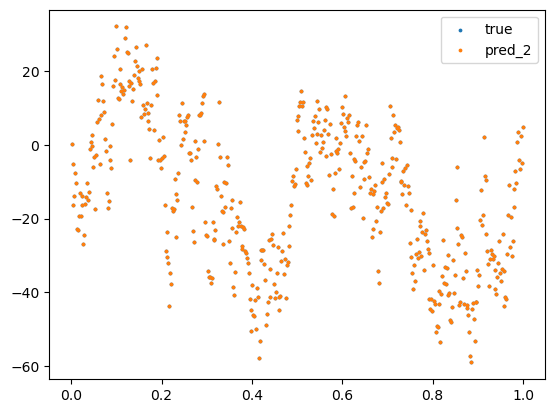

In [25]:
#plt.scatter(loc_values, meas_pred, label = 'pred', s = 3)
plt.scatter(loc_values[max_min_order], f_meas, label = 'true', s = 3)
plt.scatter(loc_values[max_min_order], a[2:], label = 'pred_2', s = 3)
plt.legend()

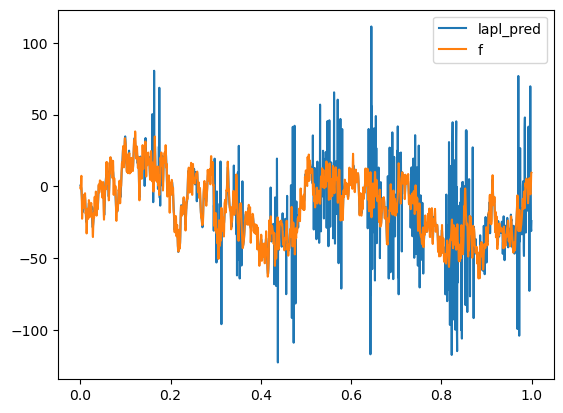

In [26]:
plt.plot(x[1:-1], lapl_pred, label = 'lapl_pred')
plt.plot(x[1:-1], f_values[1:-1], label = 'f')
plt.legend()

# No max min ordering

In [27]:
# Creating the max min ordering

loc_values_boundary = jnp.hstack([jnp.array([lower, upper]), loc_values])
max_min_order = jnp.arange(loc_values.shape[0])


In [28]:
# Reorganize the measurements according to the max min ordering
f_meas = f_meas[max_min_order]
# Reogarganize the psi matrix according to the max min ordering
psi_matrix = psi_matrix[max_min_order, :]
# Reorganize the root psi according to the max min ordering
root_psi = root_psi[max_min_order, :]

In [29]:
pred_list = []
meas_list = []
for i in n_meas_list:



    f_temp = f_meas[:i]


    # Construct the RHS of the linear system
    Y = jnp.block([jnp.zeros(shape = 2), f_temp])

    print("Number of measurements: ", Y.shape[0]-1)

    # Construct the nugget
    nugget = jnp.block([nugget_boundary*jnp.ones(shape = 2), nugget_interior*jnp.ones(shape = f_temp.shape[0])])



    # Solve the linear system
    print("Solving the linear system")
    # Select the submatrix of theta corresponding to the current measurements
    theta_temp = theta[:i+2, :i+2]

    c = scipy.linalg.solve(theta_temp + nugget*jnp.eye(theta_temp.shape[0]), Y, assume_a='pos')

    # Compute the numerical solution
    pred = evaluate_prediction(x, c, length_scale, root_psi[:i], psi_matrix[:i], boundary)
    pred_list.append(pred)


    # Compute the measurements of the true solution
    theta_eval = theta[:, :i+2]
    temp = theta_eval@c
    meas_list.append(temp)

pred_list = jnp.array(pred_list)
meas_list = jnp.array(meas_list)

Number of measurements:  11
Solving the linear system
Number of measurements:  21
Solving the linear system
Number of measurements:  31
Solving the linear system
Number of measurements:  41
Solving the linear system
Number of measurements:  51
Solving the linear system
Number of measurements:  61
Solving the linear system
Number of measurements:  71
Solving the linear system
Number of measurements:  81
Solving the linear system
Number of measurements:  91
Solving the linear system
Number of measurements:  101
Solving the linear system
Number of measurements:  111
Solving the linear system
Number of measurements:  121
Solving the linear system
Number of measurements:  131
Solving the linear system
Number of measurements:  141
Solving the linear system
Number of measurements:  151
Solving the linear system
Number of measurements:  161
Solving the linear system
Number of measurements:  171
Solving the linear system
Number of measurements:  181
Solving the linear system
Number of measureme

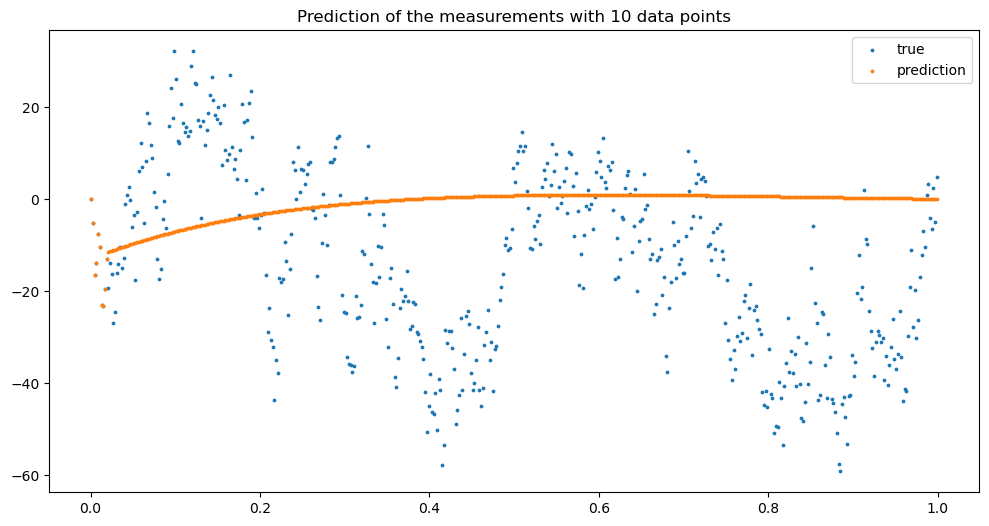

In [30]:
def update(i):
    ax.clear()
    ax.scatter(loc_values[max_min_order], f_meas, label = 'true', s = 3)
    ax.scatter(loc_values[max_min_order], meas_list[i, 2:], label = 'prediction', s = 3)
    ax.legend()
    ax.set_title(f"Prediction of the measurements with {n_meas_list[i]} data points")

# Initialize the plot
fig, ax = plt.subplots(figsize = (12,6))
animation = FuncAnimation(fig, update, frames=len(n_meas_list), interval=100, repeat=False)
HTML(animation.to_jshtml())

# With max min ordering

In [31]:
max_min_order = build_max_min_ordering(loc_values_boundary[:, None],[0,1])
max_min_order = max_min_order[2:] -2

In [32]:
# Reorganize the measurements according to the max min ordering
f_meas = f_meas[max_min_order]
# Reogarganize the psi matrix according to the max min ordering
psi_matrix = psi_matrix[max_min_order, :]
# Reorganize the root psi according to the max min ordering
root_psi = root_psi[max_min_order, :]

In [33]:
# Constructing the kernel matrix
#length_scale = 0.1
#theta_mm = construct_theta(boundary,psi_matrix, root_psi, length_scale)
max_min_augmented = jnp.hstack([jnp.arange(2), max_min_order + 2])
theta_mm = theta[max_min_augmented, :][:, max_min_augmented]


In [34]:

# theta_aa = theta[max_min_augmented, :][:, max_min_augmented]

# jnp.allclose(theta_aa, theta_mm)

In [35]:
# theta_mm = jnp.block([[theta[:2, :2], theta[:2,2: ][:, max_min_order]], [theta[2:, :2][max_min_order], theta[:2, :2][max_min_order, :][: , max_min_order]]])
# theta_mm.shape
# jnp.allclose(theta_mm.T, theta_mm)

In [36]:
pred_list = []
meas_list = []
for i in n_meas_list:



    f_temp = f_meas[:i]


    # Construct the RHS of the linear system
    Y = jnp.block([jnp.zeros(shape = 2), f_temp])

    print("Number of measurements: ", Y.shape[0]-1)

    # Construct the nugget
    nugget = jnp.block([nugget_boundary*jnp.ones(shape = 2), nugget_interior*jnp.ones(shape = f_temp.shape[0])])



    # Solve the linear system
    print("Solving the linear system")
    # Select the submatrix of theta corresponding to the current measurements
    theta_temp = theta_mm[:i+2, :i+2]

    c = scipy.linalg.solve(theta_temp + nugget*jnp.eye(theta_temp.shape[0]), Y, assume_a='pos')

    # Compute the numerical solution
    pred = evaluate_prediction(x, c, length_scale, root_psi[:i], psi_matrix[:i], boundary)
    pred_list.append(pred)


    # Compute the measurements of the true solution
    theta_eval = theta_mm[:, :i+2]
    temp = theta_eval@c
    meas_list.append(temp)

pred_list = jnp.array(pred_list)
meas_list = jnp.array(meas_list)

Number of measurements:  11
Solving the linear system
Number of measurements:  21
Solving the linear system
Number of measurements:  31
Solving the linear system
Number of measurements:  41
Solving the linear system
Number of measurements:  51
Solving the linear system
Number of measurements:  61
Solving the linear system
Number of measurements:  71
Solving the linear system
Number of measurements:  81
Solving the linear system
Number of measurements:  91
Solving the linear system
Number of measurements:  101
Solving the linear system
Number of measurements:  111
Solving the linear system
Number of measurements:  121
Solving the linear system
Number of measurements:  131
Solving the linear system
Number of measurements:  141
Solving the linear system
Number of measurements:  151
Solving the linear system
Number of measurements:  161
Solving the linear system
Number of measurements:  171
Solving the linear system
Number of measurements:  181
Solving the linear system
Number of measureme

In [37]:
n_meas_list 

Array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500],      dtype=int64)

In [38]:
i = 0
idx = n_meas_list[i]
loc_values[max_min_order[:idx]]

Array([0.501, 0.251, 0.751, 0.125, 0.375, 0.625, 0.875, 0.687, 0.187,
       0.313], dtype=float64)

In [39]:
meas_list.shape

(50, 502)

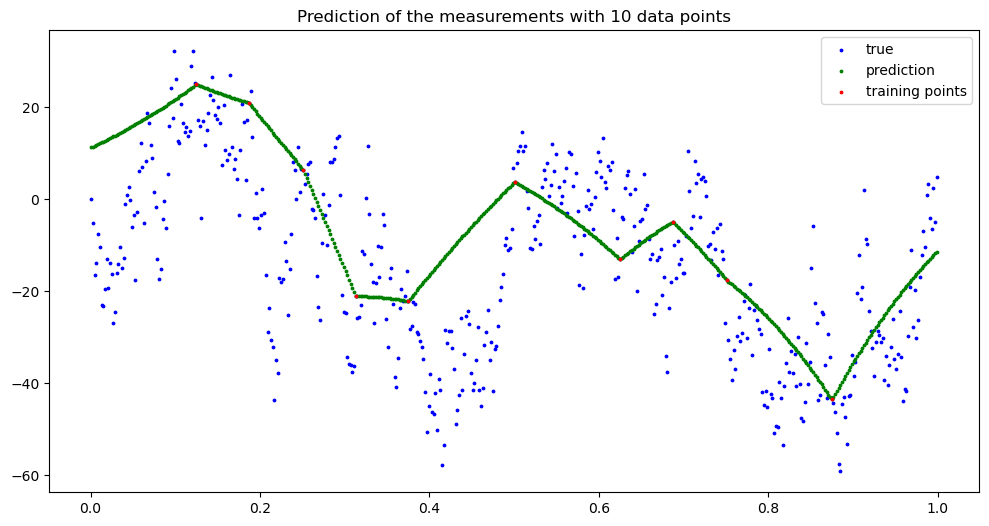

In [40]:
def update(i):
    idx = n_meas_list[i]
    ax.clear()
    ax.scatter(loc_values[max_min_order], f_meas, label = 'true', s = 3, color = "blue")
    ax.scatter(loc_values[max_min_order], meas_list[i, 2:], label = 'prediction', s = 3, color = "green")
    ax.scatter(loc_values[max_min_order[:idx]], meas_list[i, 2:idx+2], label = 'training points', color = 'red', s = 3)
    ax.legend()
    ax.set_title(f"Prediction of the measurements with {n_meas_list[i]} data points")

# Initialize the plot
fig, ax = plt.subplots(figsize = (12,6))
animation = FuncAnimation(fig, update, frames=len(n_meas_list), interval=100, repeat=False)
HTML(animation.to_jshtml())